Average improvement: 0.856
Median improvement: 0.150
Max improvement: 6.600 (aime24)
Min improvement: -5.000 (amc23)
Datasets with improvement: 9 / 16


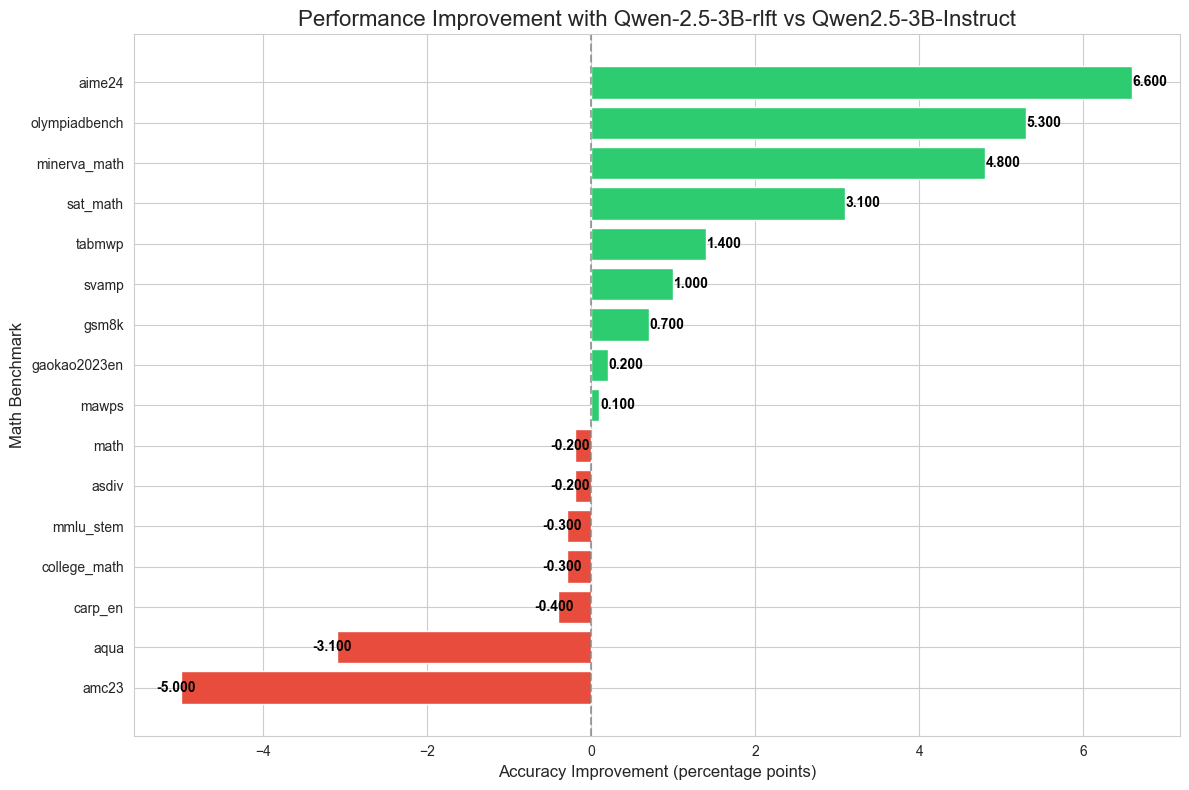

,dataset,base_acc,rlft_acc,improvement
0,aime24,6.7,13.3,6.6
1,olympiadbench,25.8,31.1,5.3
2,minerva_math,25.7,30.5,4.8
3,sat_math,93.8,96.9,3.1
4,tabmwp,90.2,91.6,1.4
5,svamp,93.1,94.1,1.0
6,gsm8k,86.6,87.3,0.7
7,gaokao2023en,54.3,54.5,0.2
8,mawps,97.2,97.3,0.1
9,math,66.6,66.4,-0.2


In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path

# prompt_type = "qwen25-math-cot"
prompt_type = "qwen25-rg-cot"

# Define model paths and names
base_path = Path("./reasoninggym-paper-experiments/math-evals")
base_model_path = base_path / "Qwen/Qwen2.5-3B-Instruct/math_eval"
rlft_model_path = base_path / "starzmustdie/Qwen-2.5-3B-rlft/math_eval"

# List all datasets (common to both models)
datasets = [d.name for d in base_model_path.iterdir() if d.is_dir()]

# Dictionary to store accuracies
results = {
    "dataset": [],
    "base_acc": [],
    "rlft_acc": [],
    "improvement": []
}

# Load accuracies for each dataset
for dataset in datasets:
    base_metrics_files = list((base_model_path / dataset).glob("*metrics.json"))
    rlft_metrics_files = list((rlft_model_path / dataset).glob(f"*metrics.json"))
    
    base_metrics_file = base_metrics_files[-1]
    rlft_metrics_file = rlft_metrics_files[-1]
    
    # Load the metrics
    with open(base_metrics_file, 'r') as f:
        base_metrics = json.load(f)
    with open(rlft_metrics_file, 'r') as f:
        rlft_metrics = json.load(f)
    
    # Extract accuracies
    base_acc = base_metrics["acc"]
    rlft_acc = rlft_metrics["acc"]
    improvement = rlft_acc - base_acc
    
    # Store in results
    results["dataset"].append(dataset)
    results["base_acc"].append(base_acc)
    results["rlft_acc"].append(rlft_acc)
    results["improvement"].append(improvement)

# Convert to DataFrame
df = pd.DataFrame(results)

# Sort by improvement - ascending=False for the display order in barh
df_sorted = df.sort_values("improvement", ascending=True).reset_index(drop=True)

# Create a cleaner plot focusing only on differences
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Create a color palette based on whether improvement is positive or negative
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in df_sorted['improvement']]

# Plot improvement bars - ensure dataset order is preserved by explicitly setting y-ticks
plt.barh(range(len(df_sorted)), df_sorted['improvement'], color=colors)
plt.yticks(range(len(df_sorted)), df_sorted['dataset'])

# Add only the improvement values as labels
for i, v in enumerate(df_sorted['improvement']):
    plt.text(v + 0.005 if v >= 0 else v - 0.3, i, 
             f"{v:.3f}", va='center', 
             color='black',
             fontweight='bold')

# Add a line at 0 to show the baseline
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

# Add titles and labels
plt.title(f"Performance Improvement with Qwen-2.5-3B-rlft vs Qwen2.5-3B-Instruct", fontsize=16)
plt.xlabel("Accuracy Improvement (percentage points)", fontsize=12)
plt.ylabel("Math Benchmark", fontsize=12)

# Calculate and display average improvement
avg_improvement = df["improvement"].mean()

# Display summary statistics
print(f"Average improvement: {avg_improvement:.3f}")
print(f"Median improvement: {df['improvement'].median():.3f}")
print(f"Max improvement: {df['improvement'].max():.3f} ({df.loc[df['improvement'].idxmax(), 'dataset']})")
print(f"Min improvement: {df['improvement'].min():.3f} ({df.loc[df['improvement'].idxmin(), 'dataset']})")
print(f"Datasets with improvement: {(df['improvement'] > 0).sum()} / {len(df)}")

# Include prompt_type in filename
plt.savefig(f"improvement_plot.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Create a table showing all the data - for table display, sort alphabetically ascending
df_display = df.sort_values("improvement", ascending=False).reset_index(drop=True)
display(df_display[["dataset", "base_acc", "rlft_acc", "improvement"]])